### 1. Preparations

* import modules, read files, make column names, convert str numbers to float

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read txt file in the current directory into a dataframe, use the first row as header

XRD = pd.read_csv('VO2 -Nb2O3 XRD Combiview.txt', sep='\t', header=None)
CT = pd.read_csv('VO2 - Nb2O3 Composition and temp Combiview.txt', sep='\t', header=None)

# rename the columns using the first row of the dataframe. Export the two theta values into a separate variable
tth = XRD.iloc[0,:]
XRD.columns = XRD.iloc[0,:]
CT.columns = CT.iloc[0,:]

# drop na, drop the first row
XRD = XRD.drop(XRD.index[0])
CT = CT.drop(CT.index[0])

# convert the dataframe to float
XRD = XRD.astype(float)
CT = CT.astype(float)

### 2. Visualize the what measurements are taken at what temperature

* a. Put all measurement points onto the correct V atm% vs. Temp graph

Text(0.5, 1.0, 'Measured Data Points')

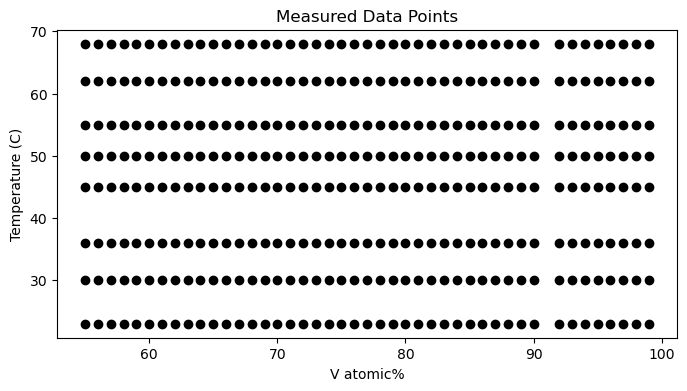

In [2]:
# scatter-plot the CT data, use the first column as x axis, the second column as y axis
plt.figure(figsize=(8,4))
plt.scatter(CT.iloc[:,0], CT.iloc[:,1], c='k', marker='o')
plt.xlabel('V atomic%')
plt.ylabel('Temperature (C)')

# set title as the name of the file
plt.title('Measured Data Points')

_Just curious: generate Heat map_

_Seems like there are three phases, let's just call them A, B, B2: A the largest, B the smaller one that is particularly visible on the second row (T = 30 C)_

_so we use T = 30C samples for the correlation analysis. There should be something to interesting to see given that both phases are prominent._

Text(0.5, 1.0, 'Diffraction - All')

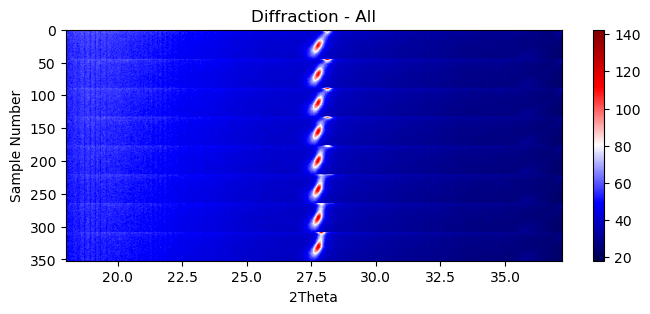

In [3]:
# plot XRD into a heatmap
plt.figure(figsize=(8, 3))
plt.imshow(XRD, cmap='seismic', aspect='auto', extent=[tth.min(), tth.max(), XRD.shape[0], 0])
plt.colorbar()
plt.xlabel('2Theta')
plt.ylabel('Sample Number')
plt.title('Diffraction - All')

* b. Make diffraction pattern vs. temperature plot (constant V composition of 99 at.%)

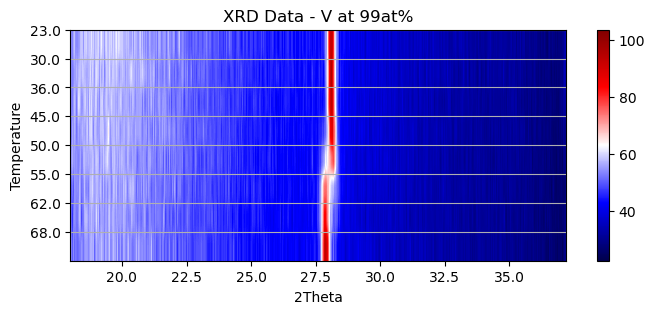

In [4]:
# find the indexes where V column has a value of 99, and store them in a list
indx = CT[CT['V'] == 99].index.tolist()

# extract the corresponding rows from XRD into a new dataframe called 'df'
df = XRD.iloc[indx]
indx_list = CT.iloc[indx, 1].tolist() # note the corresponding temp into a indx_list

# plot the heatmap of df
plt.figure(figsize=(8, 3))
plt.imshow(df, cmap='seismic', aspect='auto', extent=[tth.min(), tth.max(), df.shape[0], 0])
plt.colorbar()
plt.xlabel('2Theta')
plt.ylabel('Temperature')
plt.title('XRD Data - V at 99at%')

# horizontal grid on
plt.grid(axis='y')

# set verticle ticks as the temperature list
plt.yticks(np.arange(0, df.shape[0], 1), indx_list)

plt.show()

_Looking at the heatmap, seems like between 50 to 55 degree there is a phase transformation_

* c. Generate an x-ray diffraction versus composition plots for a constant temperature of 23

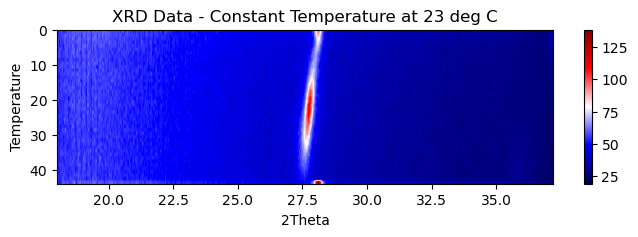

In [5]:
df = XRD.iloc[CT[CT['temp'] == 23].index.tolist()]

# Similarly, create the heat map for df @ 23 deg C
plt.figure(figsize = (8, 2))
plt.imshow(df, cmap='seismic', aspect='auto', extent=[tth.min(), tth.max(), df.shape[0], 0])
plt.colorbar()
plt.xlabel('2Theta')
plt.ylabel('Temperature')
plt.title('XRD Data - Constant Temperature at 23 deg C')

plt.show()

### 3. Perform Dimensional Reduction (on an interesting part of the dataset)

* Generate dissimilarity heat maps for samples of a constant temp = 23 C

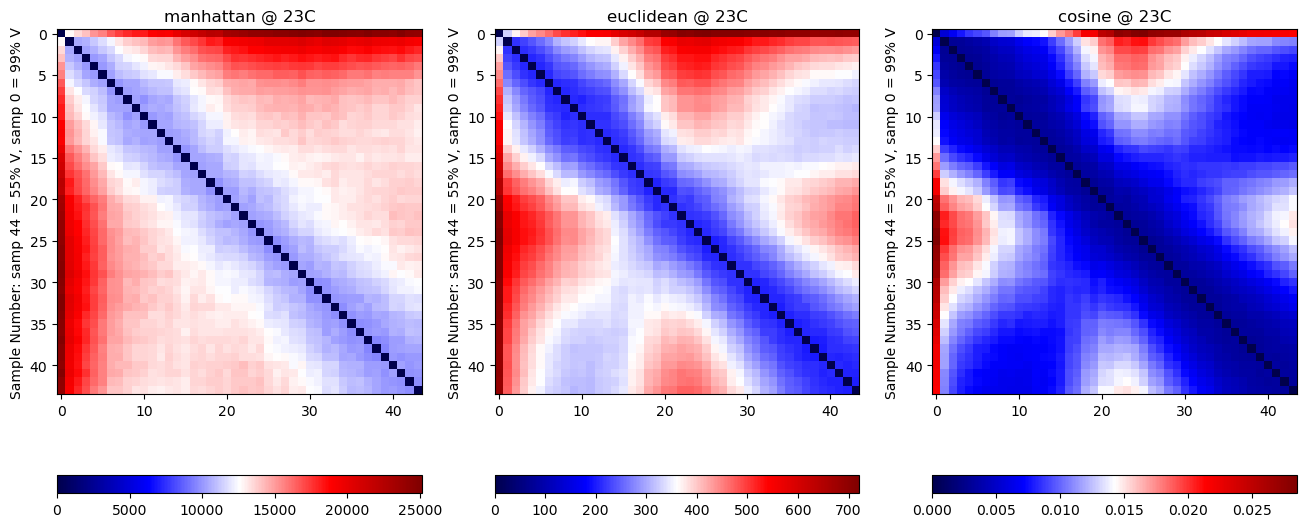

In [6]:
# select a temperature to generate the heatmap
temp = 23

# slice the XRD to get only the data corresponding to the temperature of interest
indx = CT[CT['temp'] == temp].index.tolist()

# Seems like the data is shifted...now minus 1 to each item in indx
indx = [x-1 for x in indx]
corr = XRD.iloc[indx, :]

from sklearn.metrics.pairwise import pairwise_distances

method = ['manhattan', 'euclidean', 'cosine']
plt.figure(3, figsize=(16,7))
for i in range(0, 3):
    # calculate the dissimilarity matrix between the rows of XRD
    dm1 = pairwise_distances(corr, metric= method[i])
    
    # create a subplot with 1 row and 4 columns, plot the four dissimilarity matrices
    plt.subplot(1,3,i+1)  
    plt.imshow(dm1, cmap='seismic')
    
    # set the title of each subplot
    plt.title(method[i] + ' @ ' + str(temp) + 'C')
    plt.ylabel('Sample Number: samp 44 = 55% V, samp 0 = 99% V')
    
    # turn on horizontal colorbar
    plt.colorbar(orientation='horizontal')


_Interesting that the first sample (99% V) is always very dissimilar to other samples. Suspect it is because high purity one has sharper peaks._

_Also interesting to see what's happening on the reverse diagonal line e.g. sample 10 and sample 40 has similarily, sample 15 and 32 has similarity._

### 3. Prepare for and perform PCA

* prepare data: standardize

In [7]:
# standaridize the data in XRD into a new dataframe called XRD_std
from sklearn.preprocessing import StandardScaler

array = np.array(XRD)
scaler = StandardScaler()
XRD_std = scaler.fit_transform(array)

* scatter-plot the measurement points in reduced dimension. In parallel, plot explained variance plot


Text(0.5, 1.0, 'Scree Plot')

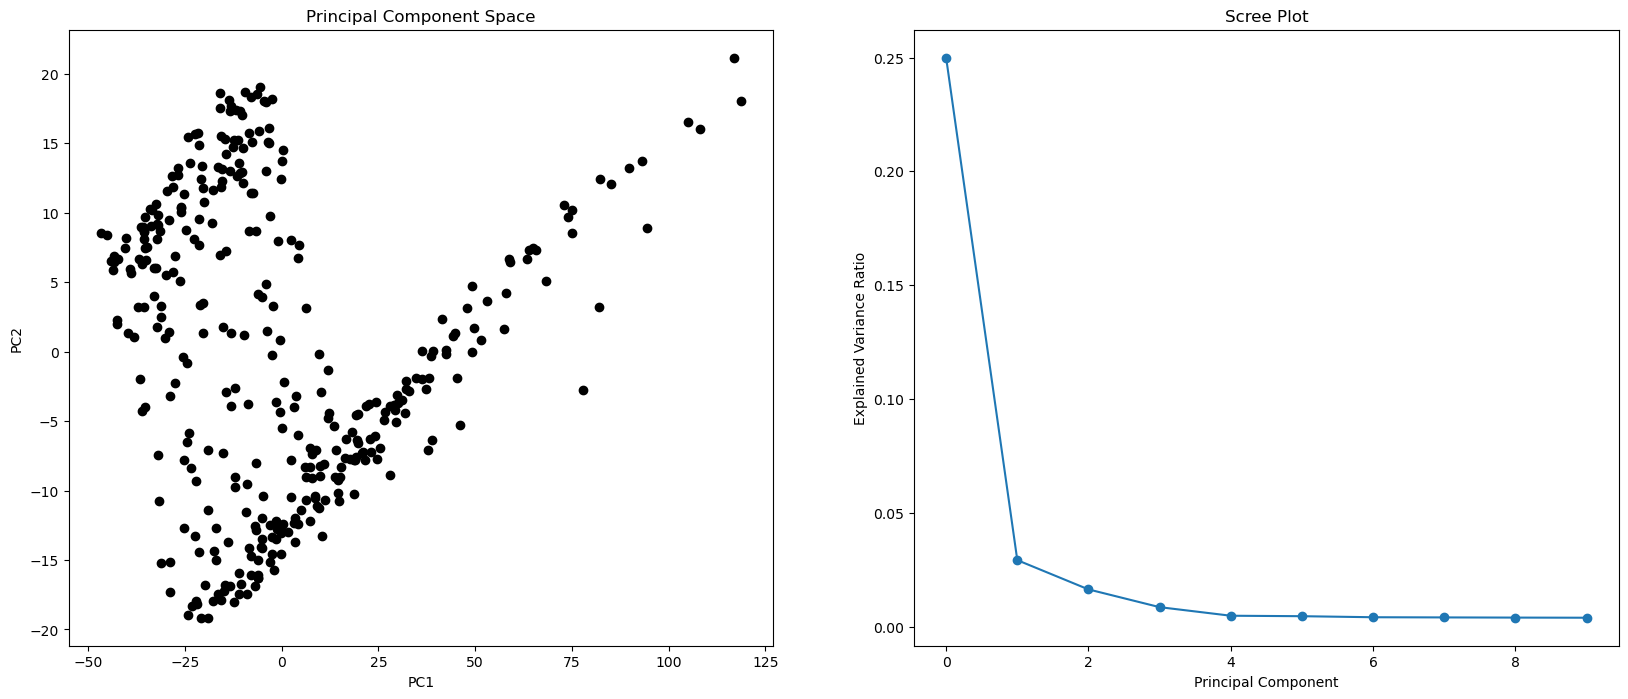

In [8]:
from sklearn.decomposition import PCA
# create a PCA object
n_comp = 10
pca = PCA(n_components=n_comp)
pca.fit(XRD_std)
pca_dots = pca.transform(XRD_std)

# make two subplots, one for pca_dots and one for the explained variance ratio
plt.figure(2, figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(pca_dots[:,0], pca_dots[:,1], c='k', marker='o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal Component Space')

plt.subplot(1,2,2) 
### now let's see what its explained variance looks like
plt.plot(pca.explained_variance_ratio_, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

_ABOVE: 2 PCs seems very good already, so we will use n_comp = 2 to denoise below_

### 4. Plot the diffraction patterns in reduced dimensional space with a false color plot

* use total explained variance to denoise, then plot the standardized & denoised data

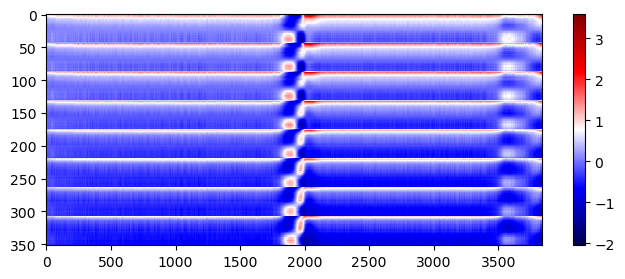

In [9]:
### Denoise, and plot the standardized & denoised data
from sklearn.decomposition import PCA
n_comp = 2 
pca = PCA(n_components=n_comp)
pca.fit(XRD_std)

pca_dots = pca.transform(XRD_std) ### actual denoise. Will update the XRD_std directly.
XRD_std = pca.inverse_transform(pca_dots)

# plot the heatmap of the de-noised data
plt.figure(figsize=(8, 3))
plt.imshow(XRD_std, cmap='seismic', aspect='auto')
plt.colorbar()

_ABOVE: graph looks smoothe, red regions compensated by blue region, can confirm stadardized!_

* this is voluntary but just trying out t-SNE below

In [10]:
# use tsne to reduce the dimensionality of XRD_array to 2D
from sklearn.manifold import TSNE
tsne = TSNE(n_components=n_comp, init='pca', learning_rate=100, random_state=1)
tsne_dots = tsne.fit_transform(XRD_std)

/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


### 5. Move on to perform clustering. 

* First we need to estimate how many clusters do we want

/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Text(0.5, 1.0, 't-SNE Spectral Clustering')

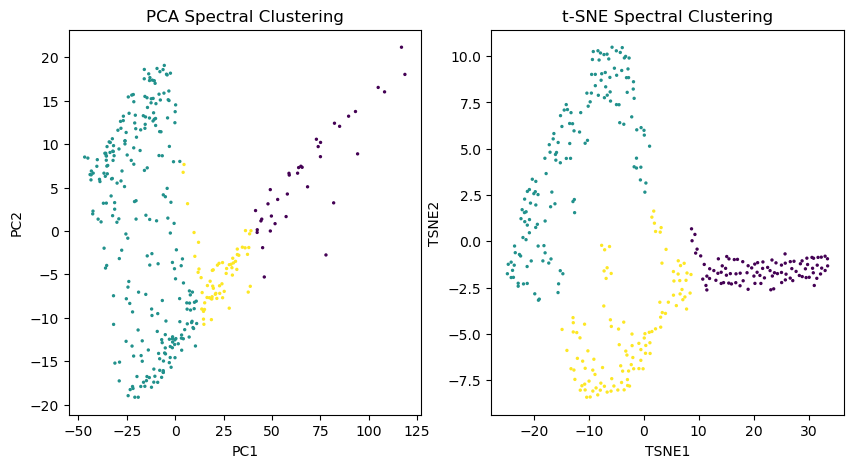

In [11]:
from sklearn.cluster import KMeans, SpectralClustering
k = 3 #number of clusters

# make two subplots, one for each clustering method
plt.figure(figsize=(10, 5))

# Plot PCA, clustered by spectral
plt.subplot(1,2,1)
PCAcluster = SpectralClustering(n_clusters=k, random_state = 1, affinity='nearest_neighbors', n_neighbors=5)
PCAcluster.fit(pca_dots)

plt.scatter(pca_dots[:,0], pca_dots[:,1], s= 2, c=PCAcluster.labels_, marker='o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Spectral Clustering')

### Plot t-SNE, also clustered by spectral
plt.subplot(1,2,2)
TSNEcluster = SpectralClustering(n_clusters=k, random_state = 1, affinity='nearest_neighbors', n_neighbors=5)
TSNEcluster.fit(tsne_dots)

plt.scatter(tsne_dots[:,0], tsne_dots[:,1], s=2 , c=TSNEcluster.labels_, marker='o')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('t-SNE Spectral Clustering')

* Finally, re-make the first diagram with the color plots

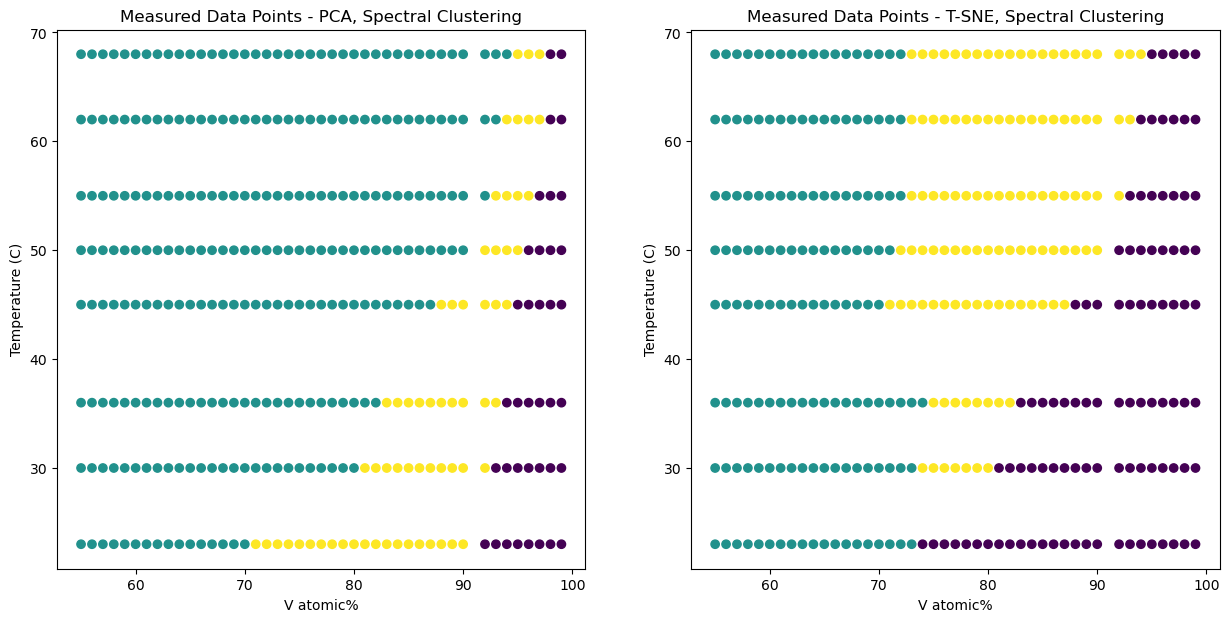

In [12]:
# plot the original data points, colored by the clustering results
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.scatter(CT.iloc[:,0], CT.iloc[:,1], c=PCAcluster.labels_, marker='o')
plt.title('Measured Data Points - PCA, Spectral Clustering')
plt.xlabel('V atomic%')
plt.ylabel('Temperature (C)')

# same for T-SNE
plt.subplot(1,2,2)
plt.scatter(CT.iloc[:,0], CT.iloc[:,1], c=TSNEcluster.labels_, marker='o')
plt.title('Measured Data Points - T-SNE, Spectral Clustering')
plt.xlabel('V atomic%')
plt.ylabel('Temperature (C)')
plt.show()

### Summary

Tell us what worked (and maybe what didn’t) and give a guess as to why. Teach us 2 lessons
you learned about your data set. (E.g. when performing PCA for dimensional reduction, if we plot PC1
and PC2 with the dielectric constant as a color map we observe that there is a cluster that mostly has a value of 0). Provide a physically plausible explanation for what material “archetypes” are contained
within the clusters and

Most of the things worked. One thing that notably didn't:
* When plotting on the phase diagram, there is no phase transition on the far right, which is not correct - the heat map at 99at% V clearly indicated phase transition at about 55C. The guess is, on the standardized & de-noised heatmap, the positions representing 99at% V is either red or white, but not blue, which indicates it's always in that phase regardless of temperature.

Learnt:
* Standardization makes a big difference on the XRD heatmap. After standardizing the data, the three phases becomes much more visible on the XRD headmap.
* what looks like a good separation between clusteres does not represent the best split. In the t-SNE cluster plot, n_neighbors=5 gives the best cluster separation, but it does not produce the most realistic phase diagram